In [19]:
# Data Tools
import numpy as np
import pandas as pd
import math
from scipy import stats
from scipy.stats import sem

# Visualization Tools
from matplotlib import pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Test/Train Split
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import LinearRegression

# Metrics
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score

# Helpful Functions
# Reference: https://people.duke.edu/~rnau/mathreg.htm
def standard_error(x_test, y_test, y_pred, p=1):
    n = len(x_test)
    e = y_test - y_pred
    RSS = (e**2).sum()
    sigma = math.sqrt(RSS / (n - (p + 1))) # estimation of standard deviation (aka residual standard error)
    SE = sigma**2 / np.sum((x_test - x_test.mean())**2)
    return math.sqrt(SE)

def residual_standard_error(y_test, y_pred):
    e = y_test - y_pred
    RSS = (e**2).sum()
    RSE = math.sqrt(RSS / (len(y_test) - 2))
    return RSE

def f_statistic(y_test, y_pred, p):
    n = len(y_test)
    e = y_test - y_pred
    RSS = (e**2).sum()
    TSS = ((y_test - y_test.mean())**2).sum()
    F = ((TSS - RSS)/p) / RSS * (n - p - 1)
    return F

def print_coefficient_stats(x_test, y_test, y_pred, lr):
    print('\n=== Coefficient Summary ===')

    for i in range(len(x_test.columns)):
        print('\n' + str(x_test.columns[i]).center(len(x_test.columns[i]) + 2, ' ').center(30, '-'))
        # Coefficient
        print('Coefficient: {:0.4f}'.format(lr.coef_[i]))

        # Standard Error
        print('Standard Error: {:0.4f}'.format(standard_error(x_test[x_test.columns[i]], y_test, y_pred, p=len(lr.coef_))))
        
        # t-statistic
        t_stat = (lr.coef_[i] / standard_error(x_test[x_test.columns[i]], y_test, y_pred, p=len(lr.coef_)))
        print('T-Statistic: {:0.4f}'.format(t_stat))

        # p Value
        p_val = stats.t.sf(np.abs(t_stat), len(x_test[x_test.columns[i]]) - 1) * 2
        print('P Value: {:0.4f}'.format(p_val))

    # Intercept
    print('\n' + str('Intercept').center(len('Intercept') + 2, ' ').center(30, '-'))
    print('Coefficient: {:0.4f}'.format(lr.intercept_))

    
# TODO: Need to fix coefficient stats for multiple linear regression (the problem occurs at the Standard Error)
# TODO: Need to include intercept in the calculations
def coefficient_stats(x_test, y_test, y_pred, lr):
    df_array = []
    headings = ['Feature', 'Coefficient', 'Standard Error', 'T_Statistic', 'p Value']
    for i in range(len(x_test.columns)):
        feature = x_test.columns[i]
        SE = standard_error(x_test[feature], y_test, y_pred, p=len(lr.coef_))
        t_stat = (lr.coef_[i] / standard_error(x_test[feature], y_test, y_pred, p=len(lr.coef_)))
        p_val = stats.t.sf(np.abs(t_stat), len(x_test[feature]) - 1) * 2 # https://stackoverflow.com/questions/17559897/python-p-value-from-t-statistic
        df_array.append([
            feature,
            lr.coef_[i],
            SE,
            t_stat,
            p_val
        ])
    return pd.DataFrame(df_array, columns=headings)

metric_funcs = [
    explained_variance_score,
    # mean_absolute_error,
    mean_squared_error,
    # mean_squared_log_error,
    # median_absolute_error,
    residual_standard_error,
    r2_score
]

def print_regression_metrics(y_test, y_pred, metric_funcs):
    print('=== Statistics Summary ===')

    for func in metric_funcs:
        print(func.__name__ + ': {:0.4f}'.format(func(y_test, y_pred)))

def regression_metrics(y_test, y_pred, metric_funcs, p=1):
    df_array = []
    headings = ['Metric', 'Value']

    for func in metric_funcs:
        df_array.append([
            ' '.join([x.capitalize() for x in func.__name__.split('_')]),
            func(y_test, y_pred)
        ])

    # F-Statistic
    if p:
        df_array.append([
            'F-Statistic',
            f_statistic(y_test, y_pred, p)
        ])

    return pd.DataFrame(df_array, columns=headings)

In [6]:
df = pd.read_csv('data/train.csv')

## Train / Test Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('SalePrice', axis=1), df.SalePrice, test_size=0.25, random_state=42)

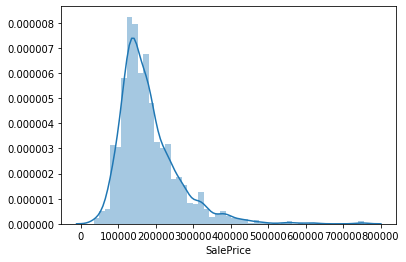

In [8]:
# Response variable distribution
sns.distplot(df.SalePrice)

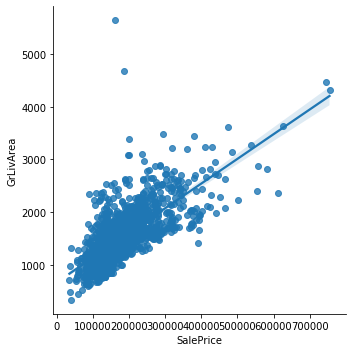

In [9]:
sns.lmplot(
    x='SalePrice',
    y='GrLivArea',
    data=df
)

In [10]:
# I want to know the R^2 of GrLivArea
lr = LinearRegression()
lr.fit(X_train.GrLivArea.values.reshape((-1, 1)), y_train)

y_pred = lr.predict(X_test.GrLivArea.values.reshape((-1, 1)))

for x, y in regression_metrics(y_test, y_pred, metric_funcs).values:
    print(x + ': {:0.2f}'.format(y))

Explained Variance Score: 0.56
Mean Absolute Error: 37052.45
Mean Squared Error: 3118447791.99
Mean Squared Log Error: 0.08
Median Absolute Error: 24286.37
Residual Standard Error: 55996.69
R2 Score: 0.55
F-Statistic: 452.45


In [20]:
# I want to know if the GrLivArea and 1stFlrSF variables are correlated w/ each other, and if it lowers the p-value

lr = LinearRegression()
columns = ['OverallQual', 'GrLivArea', '1stFlrSF', '2ndFlrSF']
lr.fit(X_train[columns], y_train)
y_pred = lr.predict(X_test[columns])

display(coefficient_stats(X_test[columns], y_test, y_pred, lr))
display(regression_metrics(y_test, y_pred, metric_funcs))

,Feature,Coefficient,Standard Error,T_Statistic,p Value
0,OverallQual,30484.906060,1436.741763,21.218083,1.304686e-65
1,GrLivArea,-17.878805,3.961575,-4.513055,8.638166e-06
2,1stFlrSF,95.559629,5.330168,17.928072,5.767767e-52
3,2ndFlrSF,60.888515,4.848727,12.557628,2.685090e-30


,Metric,Value
0,Explained Variance Score,7.867664e-01
1,Mean Squared Error,1.512661e+09
2,Residual Standard Error,3.899993e+04
3,R2 Score,7.840694e-01
4,F-Statistic,1.318096e+03


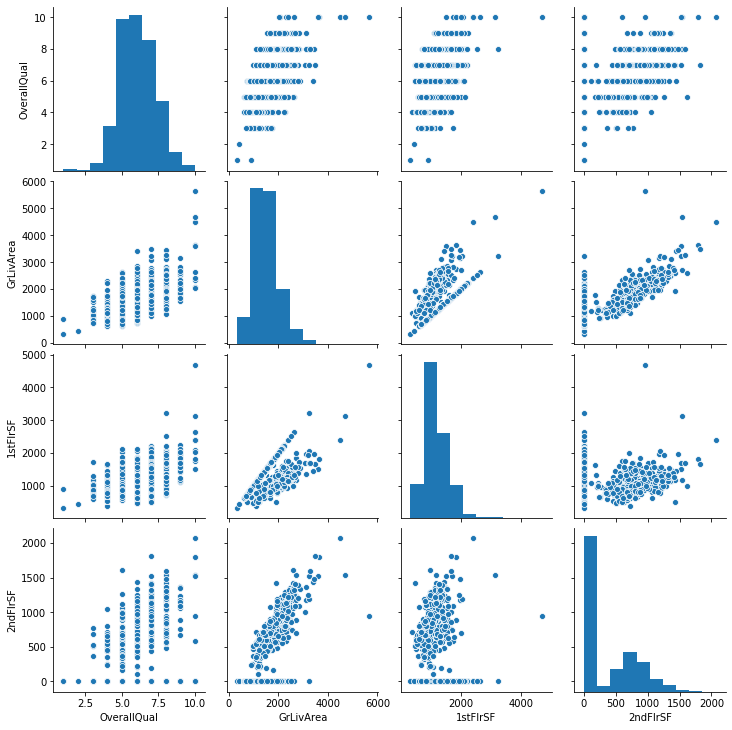

In [21]:
sns.pairplot(X_train[columns])

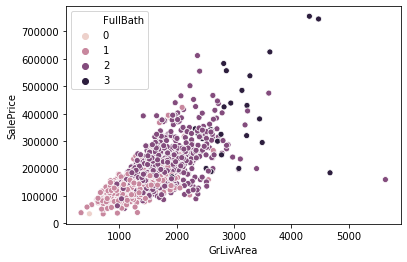

In [22]:
sns.scatterplot(
    x='GrLivArea',
    y='SalePrice',
    hue='FullBath',
    data=df
)

In [14]:
df.corr()['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

In [32]:
lr = LinearRegression()

columns = [
    'OverallQual',
    'GrLivArea',
    'GarageCars',
    # 'GarageArea',
    'TotalBsmtSF',
    '1stFlrSF',
    'FullBath',
    # 'TotRmsAbvGrd',
    'YearBuilt',
    'YearRemodAdd'
]

lr.fit(X_train[columns], y_train)
y_pred = lr.predict(X_test[columns])
display(regression_metrics(y_test, y_pred, metric_funcs))
display(coefficient_stats(X_test[columns], y_test, y_pred, lr))

,Metric,Value
0,Explained Variance Score,8.013926e-01
1,Mean Squared Error,1.403187e+09
2,Residual Standard Error,3.756219e+04
3,R2 Score,7.996966e-01
4,F-Statistic,1.449251e+03


,Feature,Coefficient,Standard Error,T_Statistic,p Value
0,OverallQual,19536.206706,1391.528162,14.039390,4.371121e-36
1,GrLivArea,50.013580,3.836906,13.034873,3.879592e-32
2,GarageCars,15474.118005,2532.209248,6.110916,2.549149e-09
3,TotalBsmtSF,14.705758,4.697226,3.130732,1.884675e-03
4,1stFlrSF,14.126591,5.162430,2.736423,6.515596e-03
5,FullBath,-7604.934215,3505.820527,-2.169231,3.071188e-02
6,YearBuilt,305.421833,68.561835,4.454692,1.119504e-05
7,YearRemodAdd,297.626800,97.405164,3.055555,2.412155e-03


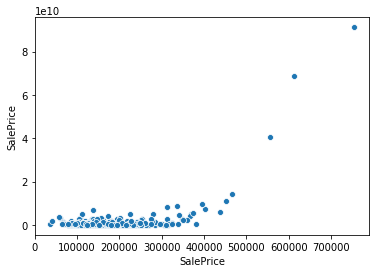

In [33]:
sns.scatterplot(
    x=y_test,
    y=(y_test - y_pred)**2
)

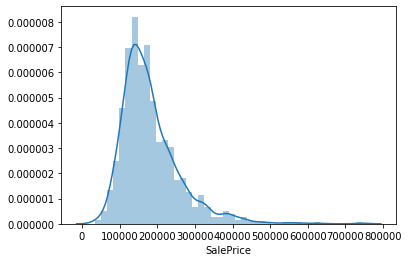

In [35]:
sns.distplot(y_train)

In [ ]:
sns.pairplot(X_train[columns])